In [1]:
import pandas as pd
import numpy as np
import pdb, argparse
import os, pdb, math, itertools
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from kdutils.macro2 import *

In [3]:
method = 'cicso0'
instruments = 'ims'
period = 5
name = 'lgbm'
task_id = '200037'

In [4]:
dirs = os.path.join(base_path, method, instruments, 'temp', "model", task_id,
                    str(period))

In [5]:
filename = os.path.join(dirs, "{0}_predict_data.feather".format(name))
filename

'./records/cicso0/ims/temp/model/200037/5/lgbm_predict_data.feather'

In [6]:
predict_data = pd.read_feather(filename)
predict_data.head()

,trade_time,code,nxt1_ret_5h,predict
0,2024-12-05 10:20:00,IM,-0.001860,-0.000025
1,2024-12-05 10:21:00,IM,-0.000716,-0.000026
2,2024-12-05 10:22:00,IM,-0.001164,-0.000041
3,2024-12-05 10:23:00,IM,-0.000192,-0.000011
4,2024-12-05 10:24:00,IM,-0.000006,-0.000013


In [7]:
is_on_mark = predict_data['trade_time'].dt.minute % int(period) == 0
predict_data = predict_data[is_on_mark]
predict_data.replace([np.inf, -np.inf], np.nan, inplace=True)
predict_data.dropna(inplace=True)
predict_data.head()

,trade_time,code,nxt1_ret_5h,predict
0,2024-12-05 10:20:00,IM,-0.001860,-0.000025
5,2024-12-05 10:25:00,IM,-0.000206,-0.000011
10,2024-12-05 10:30:00,IM,0.003050,-0.000017
15,2024-12-05 10:35:00,IM,0.004669,-0.000008
20,2024-12-05 10:40:00,IM,0.000327,-0.000025


In [8]:

# 将因子值处理成离散值
def rolling_rank_discretization(series, window=24, positive_quantile=0.9, negative_quantile=0.1):
    """
    使用严格的历史滚动窗口进行排名离散化，避免任何未来数据。

    参数:
    series: 输入数据，Pandas Series。
    window: 滚动窗口大小（默认10）。
    positive_quantile: 正方向分位数阈值（默认0.9）。
    negative_quantile: 负方向分位数阈值（默认0.1）。

    返回:
    discrete_series: 离散化后的Series，值为-1, 0, 1。
    """
    # 初始化结果Series
    discrete_series = pd.Series(index=series.index, dtype=float)
    
    # 遍历每个窗口
    for i in range(len(series)):
        if i < window - 1:
            # 窗口不足时设置为NaN
            discrete_series.iloc[i] = np.nan
            continue
            
        # 获取当前窗口数据 (严格使用过去window个点)
        window_data = series.iloc[i - window + 1: i + 1] # 包括当前点，但都是历史数据
        
        # 跳过包含NaN值的窗口
        if window_data.isna().any():
            discrete_series.iloc[i] = np.nan
            continue
        
        # 在窗口内计算排名标准化
        rank_data = window_data.rank()
        standardized = (rank_data / rank_data.sum()) - 0.5
        
        # 计算当前窗口的分位数阈值
        pos_threshold = standardized.quantile(positive_quantile)
        neg_threshold = standardized.quantile(negative_quantile)
        
        # 对窗口内的最后一个值（即当前点）进行离散化
        current_standardized = standardized.iloc[-1]
        if current_standardized >= pos_threshold:
            discrete_series.iloc[i] = 1
        elif current_standardized <= neg_threshold:
            discrete_series.iloc[i] = -1
        else:
            discrete_series.iloc[i] = 0
    
    return discrete_series

In [9]:
# 处理成离散值
predict_data['pred_alpha_disc'] = predict_data.groupby('code').apply(lambda x: rolling_rank_discretization(
    x['predict'], window=24, positive_quantile=0.7, negative_quantile=0.3)).T
predict_data

,trade_time,code,nxt1_ret_5h,predict,pred_alpha_disc
0,2024-12-05 10:20:00,IM,-0.001860,-0.000025,NaN
5,2024-12-05 10:25:00,IM,-0.000206,-0.000011,NaN
10,2024-12-05 10:30:00,IM,0.003050,-0.000017,NaN
15,2024-12-05 10:35:00,IM,0.004669,-0.000008,NaN
20,2024-12-05 10:40:00,IM,0.000327,-0.000025,NaN
...,...,...,...,...,...
15050,2025-03-12 14:40:00,IM,-0.001396,-0.000022,0.0
15055,2025-03-12 14:45:00,IM,-0.002331,-0.000004,1.0
15060,2025-03-12 14:50:00,IM,0.000454,-0.000015,0.0
15065,2025-03-12 14:55:00,IM,-0.000580,-0.000020,0.0


In [10]:
from lib.cux001 import FactorEvaluate1

In [11]:
evaluate1 = FactorEvaluate1(factor_data=predict_data,
                                factor_name='pred_alpha_disc',
                                ret_name='nxt1_ret_{0}h'.format(period),
                                roll_win=240,
                                fee=0.000012,
                                scale_method='roll_zscore',
                                expression=name)

In [12]:
stats_dt = evaluate1.run()

In [13]:
stats_dt

{'total_ret': 0.05834308137391586,
 'avg_ret': 2.082037147458743e-05,
 'max_dd': -0.023263137687834834,
 'calmar': 2.5079626900212024,
 'sharpe1': 0.03171902989733806,
 'sharpe2': 2.578599840625497,
 'turnover': 0.3785781302666383,
 'win_rate': 0.41260364842454395,
 'profit_ratio': 1.1186325898419973,
 'ic_mean': 0.041020412738639815,
 'ic_std': 0.06815912850331325,
 'ic_ir': 0.6018329993266536,
 'factor_autocorr': -0.07105428317440313,
 'ret_autocorr': -0.037199780961824996}

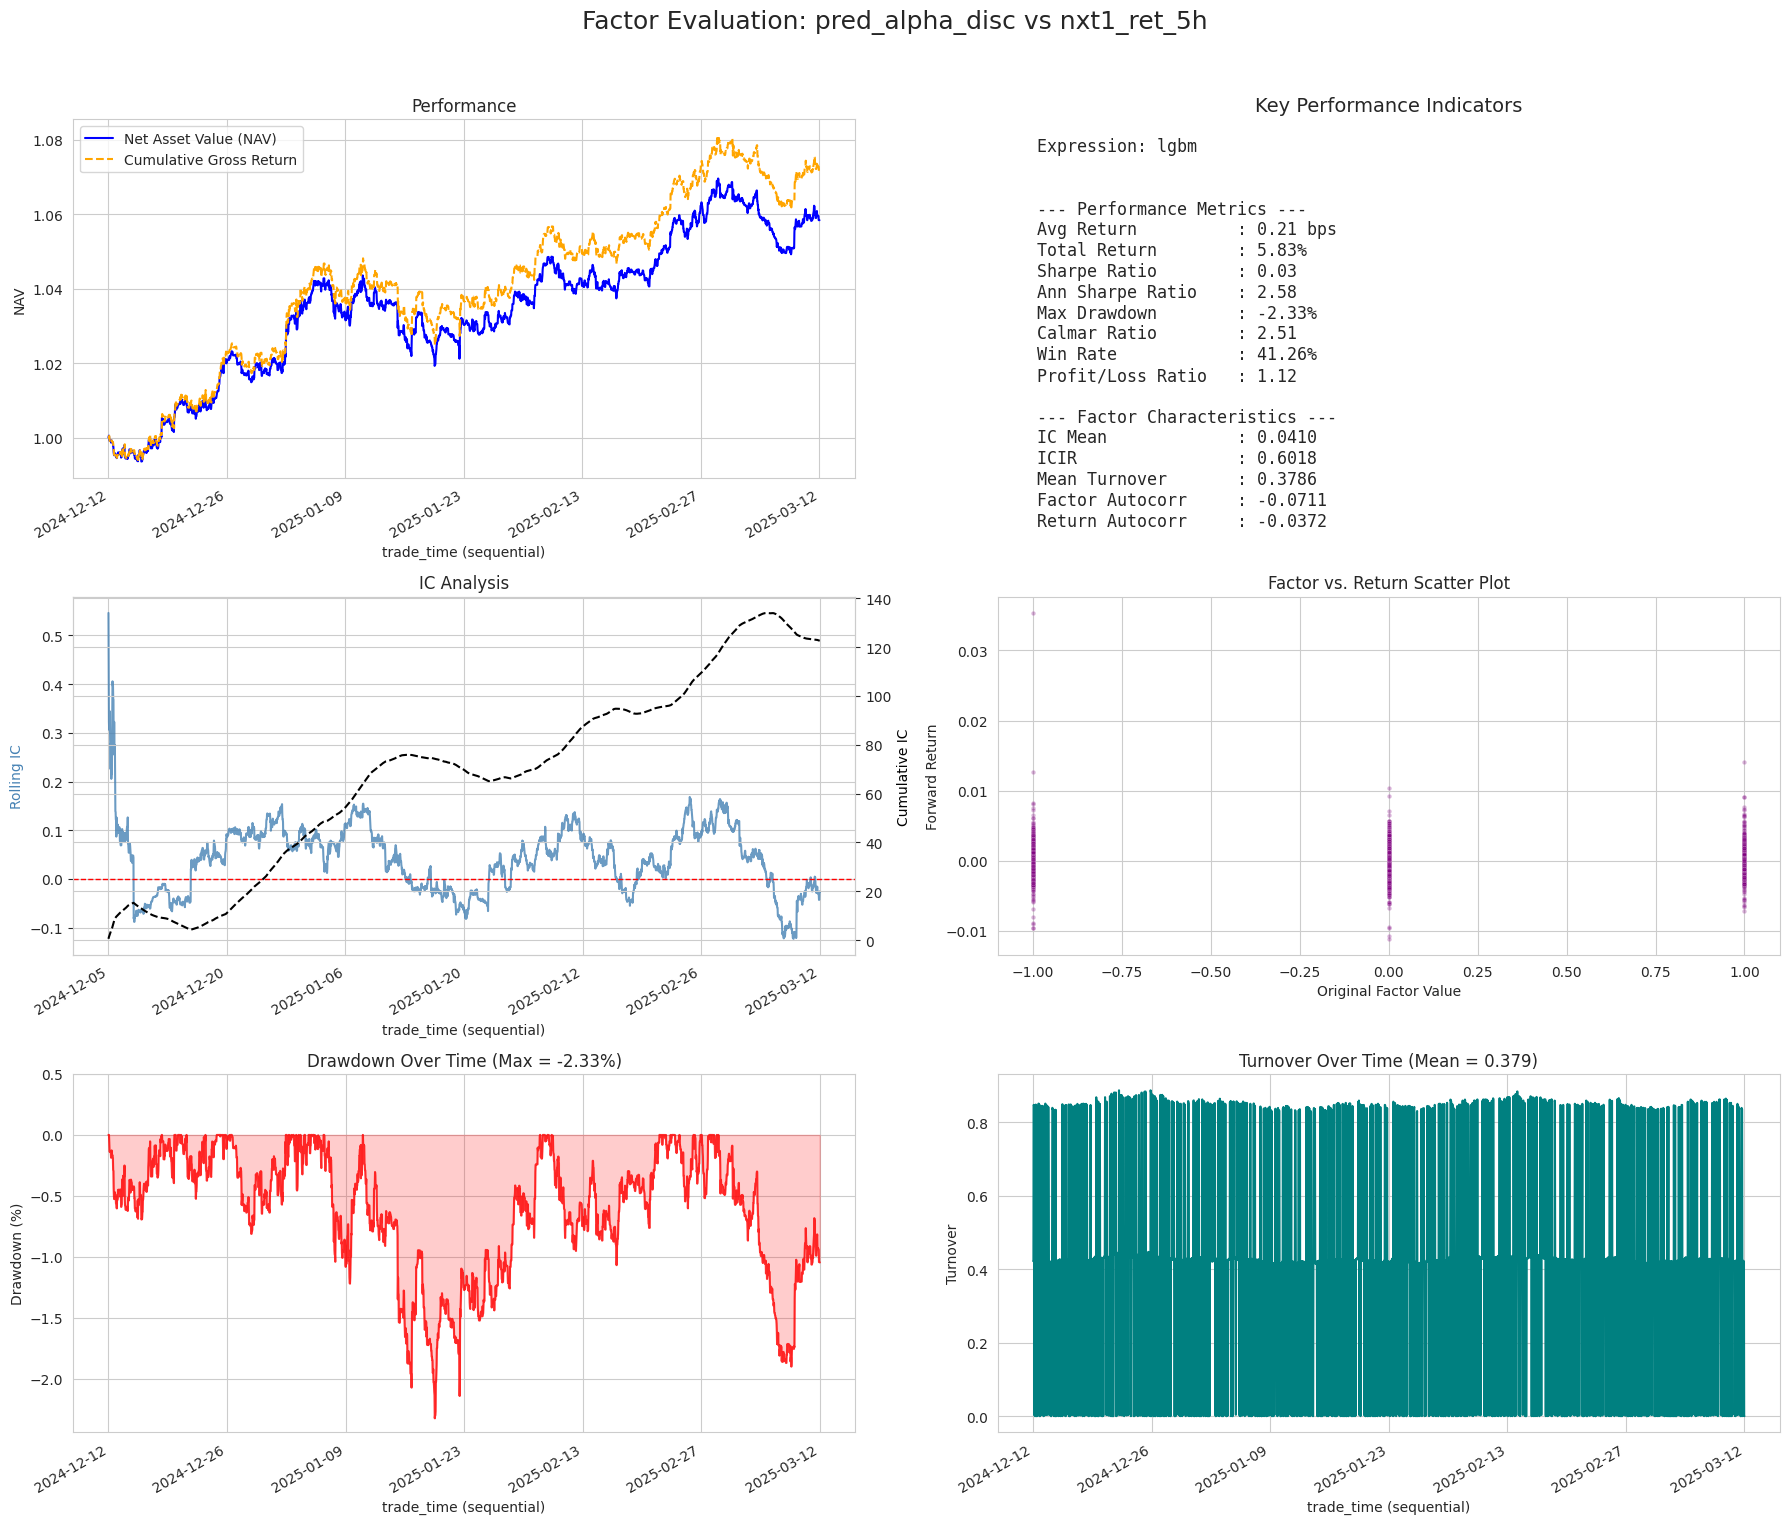

In [14]:
evaluate1.plot_results()